딥러닝기반데이터분석 과제2

2022111738 박서진

# Conv Layer & 이진 분류용 레이어 수정 모델 source code

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 데이터 준비 (Data Preparation)
- 데이터 경로 설정
- 클래스별 이미지 개수 확인


In [3]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

# 데이터 경로 설정
data_dir = '/content/drive/MyDrive/crack/crack_1000'

# 데이터 디렉토리 내 파일 및 폴더 목록 출력
for path in os.listdir(data_dir):
    print(path)

# 'positive'과 'negative' 디렉토리 내 파일 개수 출력
leng1 = len(os.listdir(data_dir + "/positive"))
leng2 = len(os.listdir(data_dir + "/negative"))
print(f"positive={leng1}, negative={leng2}")


# 학습을 위한 디바이스 설정 (GPU가 사용 가능하면 'cuda', 그렇지 않으면 'cpu' 사용)
# - torch: GPU인지 아닌지 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device={device}")



negative
positive
positive=1000, negative=1000
device=cuda


## 데이터 전처리 (Data Preprocessing)
- 이미지 크기 조정 (224x224)
- 텐서 변환
- 정규화 (Normalize)

In [ ]:

# 데이터 전처리
# - Resize: 이미지를 224x224 크기로 조정
# - ToTensor: 이미지를 텐서로 변환
# - Normalize: 각 채널의 평균과 표준편차로 정규화
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 사전 학습 가중치로 ImageNet 기반을 사용하므로, 이미지의 크기를 224x224로 맞춤

# 데이터셋 로드
# - ImageFolder: 폴더 구조를 기반으로 데이터를 불러오는 클래스
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# 전체 데이터셋의 이미지 개수 출력
total_count = len(full_dataset)
print(f"Total number of images: {total_count}")

# 데이터셋의 클래스 이름과 인덱스 매핑 정보 출력
print(full_dataset.class_to_idx)

Total number of images: 2000
{'negative': 0, 'positive': 1}


## 하이퍼파라미터 설정 (Hyperparameter Setting)
- 배치 크기 설정
- 에포크 수 설정
- 학습률 설정

In [ ]:
# 하이퍼파라미터 설정
batch_size = 64         # 배치 크기 설정 # 1400개 중에서 64개씩 묶어서 학습한다
num_epochs = 10         # 학습할 에포크 수 설정
learning_rate = 0.001   # 학습률 설정

## 데이터셋 분할 (Train, Validation, Test)
-  70% 학습 / 15% 검증 / 15% 테스트로 분할


In [ ]:
# 데이터 분할: 70% 학습 / 15% 검증 / 15% 테스트로 분할하여 학습 과정과 모델의 일반화 성능을 평가

# 데이터셋을 학습(train), 검증(validation), 테스트(test)로 분할
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# DataLoader를 사용하여 데이터셋을 배치 단위로 로드
# - shuffle: local minima에 빠질 확률이 적어진다. 학습할 때에는 shuffle 사용. val, test에서는 확인하는 과정이기에 shuffle 사용X
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# 각 데이터셋의 크기 출력
print(f"train_size={len(train_dataset)}")
print(f"val_size={len(val_dataset)}")
print(f"test_size={len(test_dataset)}")


# 배치 크기 및 전체 배치 수 확인
print(f"Batch size: {train_loader.batch_size}")
print(f"Total number of batches per epoch: {len(train_loader)}")


train_size=1400
val_size=300
test_size=300
Batch size: 64
Total number of batches per epoch: 22


## 모델 설정 (Model Setup)
- ResNet18 모델 불러오기 (pretrained=True를 통해 사전 학습된 가중치 사용)


- 첫 번째 Convolution layer 수정
- 출력 레이어 수정 (이진 분류에 맞게)

In [ ]:

# 모델 정의 (pre-trained ResNet 사용)
# 사전 학습된 ResNet18 모델을 불러오고, 출력 레이어를 2개로 변경 (이진 분류)
model = models.resnet18(pretrained=True)

# 첫 번째 Convolution Layer 수정
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

# 마지막 레이어를 Binary Classification로 설정
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

# ResNet18 모델 요약: 깊은 네트워크 구조를 사용해 계산 비용이 높고 복잡한 패턴 학습에 적합


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 194MB/s]


## 손실 함수 및 옵티마이저 설정 (Loss Function & Optimizer)
- 손실 함수: CrossEntropyLoss
- 옵티마이저: Adam (learning rate 설정)

In [ ]:
# 손실 함수와 옵티마이저 설정
# 손실 함수: CrossEntropyLoss 사용, 최적화 기법으로 Adam 선택
# - CrossEntropyLoss: 분류 문제에서 사용되는 손실 함수
# - Adam 옵티마이저: 가중치 업데이트에 사용되는 최적화 알고리즘
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## 학습 및 검증 함수 정의 (Define Train and Validation Functions)
- train 함수: 학습 데이터로 모델의 가중치를 업데이트
- validate 함수: 검증 데이터를 통해 모델의 성능 평가

In [ ]:
# 학습 및 검증 함수 정의
# 학습 함수 정의
# - 모델을 학습 모드로 설정하고 배치 단위로 손실을 계산 및 가중치 업데이트
def train(model, loader, criterion, optimizer):
    model.train()           # 모델을 학습 모드로 설정
    running_loss = 0.0      # 손실 초기화
    correct = 0             # 정확도 계산을 위한 변수 초기화
    total = 0
    num_batches = len(loader)
    print(f"num_batches={num_batches}")

    for i, (images, labels) in enumerate(loader):
        print(f"[{i+1}/{num_batches}]", end=" ")
        images, labels = images.to(device), labels.to(device)
        # print(f"images.shape={images.shape}")
        # print(f"labels.shape={labels.shape}")
        # print(f"labels={labels}")
        optimizer.zero_grad()     # 이전 단계의 그래디언트 0으로 초기화
        outputs = model(images)   # 모델에 입력 데이터를 통과시켜 출력 계산 # outputs: Y'값
        # criterion함수: loss 함수
        loss = criterion(outputs, labels)   # 출력과 실제 라벨 간의 손실 계산
        loss.backward()           # 그래디언트 계산
        optimizer.step()          # 모델 가중치 업데이트

        running_loss += loss.item() * images.size(0)  # 전체 손실 누적
        _, predicted = torch.max(outputs, 1)          # 예측값 계산
        total += labels.size(0)
        correct += (predicted == labels).sum().item() # 맞춘 개수 계산

    return running_loss / total, correct / total      # 평균 손실과 정확도 변환

# 검증 함수 정의
# - 학습된 모델의 검증 데이터 성능을 평가
def validate(model, loader, criterion):
    model.eval()                # 모델을 평가 모드로 설정
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():       # 평가 시에는 그래디언트 계산 비활성화
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)  # max: Negative, Postive 노드 둘 중에 어디가 더 크냐
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return running_loss / total, correct / total


## 학습 수행 (Training Process)
- 각 에포크마다 train과 validate 함수를 호출하여 학습 및 검증 수행
- 손실과 정확도를 기록

In [ ]:
# 학습 및 검증 기록을 위한 리스트
train_losses = []
val_losses = []
val_accuracies = []

# 학습 과정
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")





num_batches=22
[1/22] [2/22] [3/22] [4/22] [5/22] [6/22] [7/22] [8/22] [9/22] [10/22] [11/22] [12/22] [13/22] [14/22] [15/22] [16/22] [17/22] [18/22] [19/22] [20/22] [21/22] [22/22] Epoch [1/10], Train Loss: 0.1630, Validation Loss: 0.0600, Validation Accuracy: 0.9733
num_batches=22
[1/22] [2/22] [3/22] [4/22] [5/22] [6/22] [7/22] [8/22] [9/22] [10/22] [11/22] [12/22] [13/22] [14/22] [15/22] [16/22] [17/22] [18/22] [19/22] [20/22] [21/22] [22/22] Epoch [2/10], Train Loss: 0.0363, Validation Loss: 0.0110, Validation Accuracy: 0.9967
num_batches=22
[1/22] [2/22] [3/22] [4/22] [5/22] [6/22] [7/22] [8/22] [9/22] [10/22] [11/22] [12/22] [13/22] [14/22] [15/22] [16/22] [17/22] [18/22] [19/22] [20/22] [21/22] [22/22] Epoch [3/10], Train Loss: 0.0118, Validation Loss: 0.0081, Validation Accuracy: 1.0000
num_batches=22
[1/22] [2/22] [3/22] [4/22] [5/22] [6/22] [7/22] [8/22] [9/22] [10/22] [11/22] [12/22] [13/22] [14/22] [15/22] [16/22] [17/22] [18/22] [19/22] [20/22] [21/22] [22/22] Epoch [4/10

## 학습 결과 시각화 (Visualization of Training Results)
- 학습 손실 및 검증 손실을 그래프로 시각화
- 검증 정확도 변화 시각화

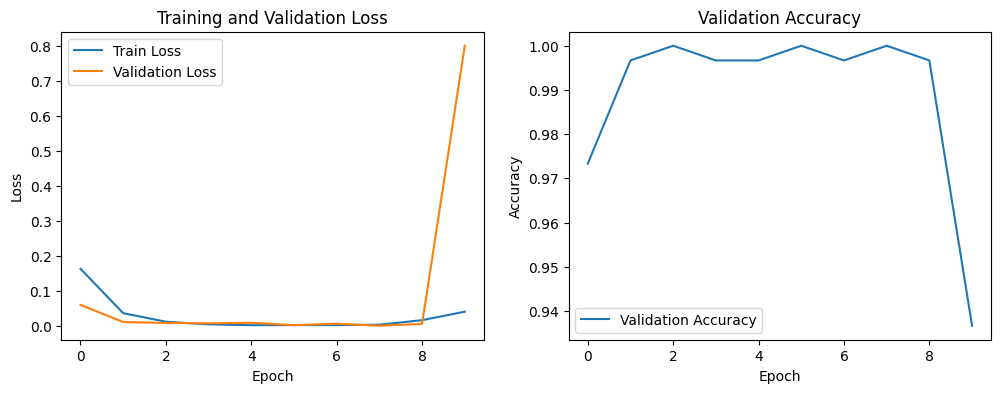

In [ ]:
# 학습 결과 시각화
plt.figure(figsize=(12, 4))

# 학습 및 검증 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# 검증 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.show()

## 테스트 데이터로 평가 (Evaluation on Test Data)
- 테스트 데이터를 이용하여 모델의 최종 성능 평가
- 테스트 손실 및 정확도 출력

In [ ]:
# 테스트 데이터로 최종 성능 평가
test_loss, test_acc = validate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.8410, Test Accuracy: 0.9300


## 모델 가중치 저장 (Save Model Weights)
- 학습이 완료된 모델의 가중치를 파일로 저장하여 나중에 재사용할 수 있도록 함

In [ ]:
save_path = '/content/drive/MyDrive/crack/weights_resnet18.pth'

# 모델의 가중치를 저장
torch.save(model.state_dict(), save_path)

In [ ]:
model.load_state_dict((torch.load(save_path)))

<ipython-input-13-45452117ba28>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict((torch.load(save_path)))


<All keys matched successfully>